In [119]:
import sys
import warnings
warnings.filterwarnings("ignore")

import cv2
from keras.models import load_model
import numpy as np

from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.inference import load_image
from utils.preprocessor import preprocess_input
import tensorflow as tf
from keras.models import Model

In [64]:
# hyper-parameters for bounding boxes shape
gender_offsets = (30, 60)
gender_offsets = (10, 10)
emotion_offsets = (20, 40)
emotion_offsets = (0, 0)

In [65]:
detection_model_path = '../trained_models/detection_models/haarcascade_frontalface_default.xml'
emotion_model_path = '../trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5'
gender_model_path = '../trained_models/gender_models/simple_CNN.81-0.96.hdf5'

In [66]:
emotion_labels = get_labels('fer2013')
gender_labels = get_labels('imdb')

In [55]:
image_path = '../../Dataset/img_align_celeba/000001.jpg'

In [67]:
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
gender_classifier = load_model(gender_model_path, compile=False)

In [68]:

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]
gender_target_size = gender_classifier.input_shape[1:3]

In [8]:
from keras.preprocessing import image


In [11]:
# def remove_transparency(im, bg_colour=(255, 255, 255)):

#     # Only process if image has transparency 
#     if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

#         # Need to convert to RGBA if LA format due to a bug in PIL 
#         alpha = im.convert('RGBA').split()[-1]

#         # Create a new background image of our matt color.
#         # Must be RGBA because paste requires both images have the same format

#         bg = Image.new("RGBA", im.size, bg_colour + (255,))
#         bg.paste(im, mask=alpha)
#         return bg

#     else:
#         return im

In [13]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
def converter(x):

    #x has shape (batch, width, height, channels)
    return (0.21 * x[:,:,:1]) + (0.72 * x[:,:,1:2]) + (0.07 * x[:,:,-1:])

In [56]:
target_size=None
from skimage import io
from skimage.color import rgb2gray
from skimage import img_as_ubyte
rgb_img = io.imread(image_path)

In [57]:
rgb_image=image.img_to_array(image.load_img(image_path, target_size=None,color_mode='rgb'))
# gray_img=rgb2gray(rgb_img)
# gray_image = img_as_ubyte(gray_img)
gray_image=converter(rgb_image)
# print(gray_image.shape)
gray_image = np.squeeze(gray_image)
gray_image = gray_image.astype('uint8')
gray_image.shape

(218, 178)

In [19]:
import lime 

In [20]:
from lime import lime_image

In [21]:
explainer = lime_image.LimeImageExplainer()

In [282]:
# def gender_preprocess
# def gender_predict

gray_image=converter(rgb_img)
# print(gray_image.shape)
gray_image = np.squeeze(gray_image)
gray_image = gray_image.astype('uint8')
# print('HERE....')
faces = detect_faces(face_detection, gray_image)
print(len(faces))

1


In [41]:
import random
def emotion_predict(img):
    gray_image=converter(img)
    # print(gray_image.shape)
    gray_image = np.squeeze(gray_image)
    gray_image = gray_image.astype('uint8')
    faces = detect_faces(face_detection, gray_image)

    if len(faces)==0:
        rand_index=random.randint(0,6)
        ret_arr=np.zeros((1,7))
        ret_arr[0][rand_index]=1.0
        return ret_arr
    
    x1, x2, y1, y2 = apply_offsets(faces[0], emotion_offsets)
    gray_face = gray_image[y1:y2, x1:x2]
    gray_face = cv2.resize(gray_face, (emotion_target_size))

    gray_face = preprocess_input(gray_face, True)
    gray_face = np.expand_dims(gray_face, 0)
    gray_face = np.expand_dims(gray_face, -1)
    return emotion_classifier.predict(gray_face)

In [166]:
import numpy as np
emotion_predict(rgb_img)*100
# np.zeros((1,7))

array([[ 0.297,  0.   ,  0.688, 19.134,  0.696,  0.393, 78.793]],
      dtype=float32)

In [43]:
np.zeros((1,7)).astype('float32')

array([[0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [44]:
# display(image.load_img(image_path, target_size=None,color_mode='rgba
# image.img_to_array(test_img)
# x = np.expand_dims(rgb_img, axis=0)
# x.shape

In [107]:
explanation = explainer.explain_instance(rgb_img, emotion_predict, top_labels=7, hide_color=0, num_samples=1000,batch_size=1)

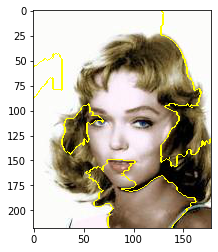

In [117]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
%matplotlib inline
temp, mask = explanation.get_image_and_mask(explanation.top_labels[6], positive_only=True, num_features=6, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

In [112]:
explanation.top_labels

[1, 6, 5, 4, 3, 2, 0]

In [94]:
data_path='../../Dataset/img_align_celeba/'
output_dict={}
for file in os.listdir(data_path):
    rgb_img = io.imread(os.path.join(data_path,file))
    output=emotion_predict(rgb_img)[0]
    output_dict[file]={emotion_labels[i]:np.round(output[i]*100,2) for i in range(len(emotion_labels))}

In [97]:
import json

with open('emotion_results.json', 'w') as fp:
    json.dump(output_dict, fp)

In [99]:
emokeys=list(output_dict.keys())
for i in range(len(emokeys)):
    if i==1000:
        break
    print(emokeys[i],output_dict[emokeys[i]])

000001.jpg {'angry': 0.13, 'disgust': 0.0, 'fear': 0.05, 'happy': 98.87, 'sad': 0.02, 'surprise': 0.25, 'neutral': 0.68}
000002.jpg {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 95.59, 'sad': 0.0, 'surprise': 4.24, 'neutral': 0.17}
000003.jpg {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 100.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}
000004.jpg {'angry': 100.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 0.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}
000005.jpg {'angry': 0.44, 'disgust': 0.0, 'fear': 0.36, 'happy': 1.71, 'sad': 0.8, 'surprise': 0.05, 'neutral': 96.64}
000006.jpg {'angry': 0.43, 'disgust': 0.01, 'fear': 1.26, 'happy': 0.59, 'sad': 7.71, 'surprise': 0.09, 'neutral': 89.9}
000007.jpg {'angry': 0.18, 'disgust': 0.0, 'fear': 1.92, 'happy': 0.68, 'sad': 1.97, 'surprise': 0.13, 'neutral': 95.11}
000008.jpg {'angry': 20.73, 'disgust': 0.0, 'fear': 2.05, 'happy': 0.26, 'sad': 8.75, 'surprise': 0.07, 'neutral': 68.15}
000009.jpg {'angry': 0.02, 'disgust': 0.0, 'f

In [162]:
feat_extractor = Model(inputs=emotion_classifier.input, outputs=emotion_classifier.get_layer("conv2d_7").output)


In [205]:
def feature_extractor(img):
    gray_image=converter(img)
    # print(gray_image.shape)
    gray_image = np.squeeze(gray_image)
    gray_image = gray_image.astype('uint8')
    faces = detect_faces(face_detection, gray_image)

    if len(faces)==0:
        return None
    
    x1, x2, y1, y2 = apply_offsets(faces[0], emotion_offsets)
    gray_face = gray_image[y1:y2, x1:x2]
    gray_face = cv2.resize(gray_face, (emotion_target_size))

    gray_face = preprocess_input(gray_face, True)
    gray_face = np.expand_dims(gray_face, 0)
    gray_face = np.expand_dims(gray_face, -1)
    feat_out=feat_extractor.predict(gray_face)[0]
    # feat_out.shape
    feat_out=np.array([np.ndarray.flatten(feat_out)])
    return feat_out

In [206]:
except_list=['002715.jpg',
'005424.jpg',
'014893.jpg',
'016986.jpg',
'023984.jpg',
'031787.jpg',
'036260.jpg',
'041431.jpg',
'044120.jpg',
'052332.jpg',
'053685.jpg',
'057093.jpg',
'070428.jpg',
'076224.jpg',
'078874.jpg',
'080583.jpg',
'081789.jpg',
'096776.jpg',
'101170.jpg',
'103761.jpg',
'104520.jpg',
'105255.jpg',
'106158.jpg',
'119593.jpg',
'121173.jpg',
'121224.jpg',
'123602.jpg',
'125060.jpg',
'126589.jpg',
'127854.jpg',
'133832.jpg',
'139631.jpg',
'142416.jpg',
'142996.jpg',
'144243.jpg',
'151721.jpg',
'157974.jpg',
'159541.jpg',
'161275.jpg',
'167056.jpg',
'169444.jpg',
'178911.jpg',
'178983.jpg',
'186886.jpg',
'196665.jpg']

In [207]:
from random import sample 
all_images=[file for file in os.listdir(data_path) if file not in except_list]
sample_image_list=sample(all_images,1500)

In [220]:
feature_list=[]
image_list=[]
for elem in sample_image_list:
    rgb_img = io.imread(os.path.join(data_path,elem))
    output=feature_extractor(rgb_img)
    if output is not None:
        image_list.append(elem)
        feature_list.append(list(output[0]))

In [204]:
from collections import Counter

In [210]:
from sklearn.decomposition import PCA
features = np.array(feature_list)
pca = PCA(n_components=50)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [211]:
pca_features = pca.transform(features)

In [221]:
images=[os.path.join(data_path,img) for img in image_list]

In [222]:
import pickle

pickle.dump([images, pca_features, pca], open('pcafeatures.p', 'wb'))

In [223]:
data_path

'../../Dataset/img_align_celeba/'

In [224]:
import shutil
import os

src_dir = "../../Dataset/img_align_celeba"
dst_dir = "../../Dataset/dataset"

In [225]:
for imageName in image_list:
    shutil.copy(os.path.join(src_dir, imageName), dst_dir)